Натренувати як мінімум 2 моделі кластеризації.

Підібрати оптимальну кількість кластерів використовуючи як мінімум 2 метрики.

Побудувати графік втрати інформації при зменшенні розмірності.

Знайти оптимальну кількість кластерів і розбиття на кластери на перетворенному датасеті.

Порівняти розбиття екземплярів на кластери для повного датасету і після втраті 30% інформації.

https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29


## INIT BLOCK

### Import and install Requirements

### install

In [ ]:
!pip install clustergram

In [ ]:
!pip3 install -U scikit-learn

### import

In [ ]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import (AgglomerativeClustering, Birch, DBSCAN, HDBSCAN, KMeans, AffinityPropagation, MeanShift, OPTICS)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score)
from sklearn.preprocessing import (StandardScaler, RobustScaler, PowerTransformer)
from clustergram import Clustergram

### Init

In [ ]:
RANDOM_STATE: int = 1729


def mount_google_drive() -> bool | None:
    """
    Function to mount Google Drive.
    :return: True if mounting is successful, None otherwise.
    """
    try:
        from google.colab.drive import mount

        mount(mountpoint="/content/drive")
        return True

    except Exception as error:
        print(f"Error while mounting Google Drive: {error}")
        raise


def get_data_frame(dataset_path: str, *args, sep: str = ",", **kwargs) -> pd.DataFrame | None:
    """
    Function to convert the dataset into a pd.DataFrame.
    :param sep: Separator for csv data, default - ",".
    :param dataset_path: Path or URL of the dataset.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    try:
        return pd.read_csv(filepath_or_buffer=dataset_path, sep=sep, **kwargs)

    except Exception as error:
        print(f"Error while converting dataset to NumPy array: {error}")
        raise


def main(dataset_path: str, *args, **kwargs) -> pd.DataFrame | None:
    """
    Main function to start the app.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    if mount_google_drive():
        import os

        if os.path.exists(path=dataset_path):
            return get_data_frame(dataset_path=dataset_path, *args, **kwargs)

        else:
            print("Dataset path doesn't exists.")
            raise FileNotFoundError


if __name__ == "__main__":
    source_dataframe: pd.DataFrame | None = main(dataset_path="/content/drive/MyDrive/Hillel/Machine_Learning_Course/HW11/SouthGermanCredit.asc", sep=" ")

    if isinstance(source_dataframe, pd.DataFrame):
        working_dataframe: pd.DataFrame = source_dataframe.copy()

        features: list = ["laufkont", "laufzeit", "moral", "verw", "hoehe", "sparkont", "beszeit", "rate", "famges", "buerge",
                          "wohnzeit", "verm", "alter", "weitkred", "wohn", "bishkred", "beruf", "pers", "telef", "gastarb", "kredit"]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data analysis, clining and optomization

### DataFrame info

In [ ]:
working_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   laufkont  1000 non-null   int64
 1   laufzeit  1000 non-null   int64
 2   moral     1000 non-null   int64
 3   verw      1000 non-null   int64
 4   hoehe     1000 non-null   int64
 5   sparkont  1000 non-null   int64
 6   beszeit   1000 non-null   int64
 7   rate      1000 non-null   int64
 8   famges    1000 non-null   int64
 9   buerge    1000 non-null   int64
 10  wohnzeit  1000 non-null   int64
 11  verm      1000 non-null   int64
 12  alter     1000 non-null   int64
 13  weitkred  1000 non-null   int64
 14  wohn      1000 non-null   int64
 15  bishkred  1000 non-null   int64
 16  beruf     1000 non-null   int64
 17  pers      1000 non-null   int64
 18  telef     1000 non-null   int64
 19  gastarb   1000 non-null   int64
 20  kredit    1000 non-null   int64
dtypes: int64(21)
memory usage: 164.2 KB


### DataFrame head

In [ ]:
working_dataframe.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


### Перевіряємо на дублікати

In [ ]:
print(f"{'Є дублікати, потрібна обробка датасету.' if working_dataframe.duplicated().sum() else 'Дублікатів немає.'}", end="\n\n")

Дублікатів немає.



### Обробка відсутніх значеннь

In [ ]:
print(f"{'Є пропущені значення, потрібна обробка датасету.' if working_dataframe.isna().any().any() else 'Пропущених значень немає.'}", end="\n\n")

Пропущених значень немає.



### Генеруємо статистику

In [ ]:
working_dataframe.describe(include="all", percentiles=[.25, .5, .75])

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,1.145000,...,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.845000,1.404000,1.963000,0.700000
std,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,...,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,1.000000,...,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,1.000000,...,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,1.000000,...,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,...,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000


# Feature Engineering

### Перевіряємо кореляцію даних

<Axes: >

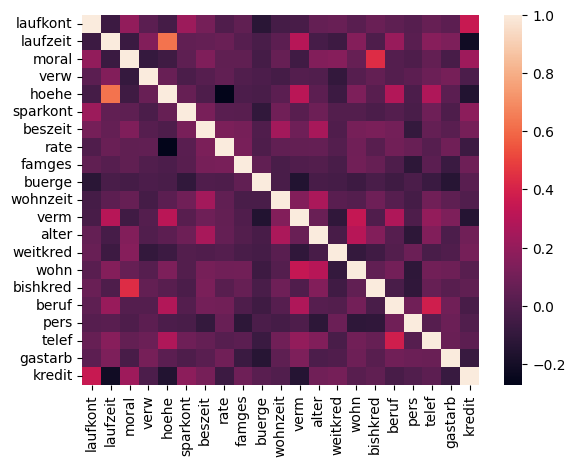

In [ ]:
working_dataframe_corr_matrix: pd.DataFrame = working_dataframe.corr()
sns.heatmap(data=working_dataframe_corr_matrix)

Кореляції між фічами немає.

# Preparing data for training

### Масштабування фічів

In [ ]:
scaler: StandardScaler = StandardScaler().fit(X=working_dataframe)

x_scaled: np.ndarray = scaler.transform(X=working_dataframe)

# FIT PREDICT

### Functions for fit models, make predict and generate metrics

In [ ]:
def count_uniques(array):
    unique_values, value_counts = np.unique(ar=array, return_counts=True)

    for value, count in zip(unique_values, value_counts):
        print(f"Значень {value}: {count}")

In [ ]:
def make_matrics(X, labels) -> None:
    silhouette: np.float64 = silhouette_score(X=X, labels=labels, random_state=RANDOM_STATE)
    calinski_harabasz: np.float64 = calinski_harabasz_score(X=X, labels=labels)
    davies_bouldin: np.float64 = davies_bouldin_score(X=X, labels=labels)

    print(f"Silhouette Score (MAX is BETTER):        {silhouette}")
    print(f"Calinski-Harabasz Index (MAX is BETTER): {calinski_harabasz}")
    print(f"Davies-Bouldin Index (MIN is BETTER):    {davies_bouldin}", end="\n\n")

### CLASTEROGRAM

<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

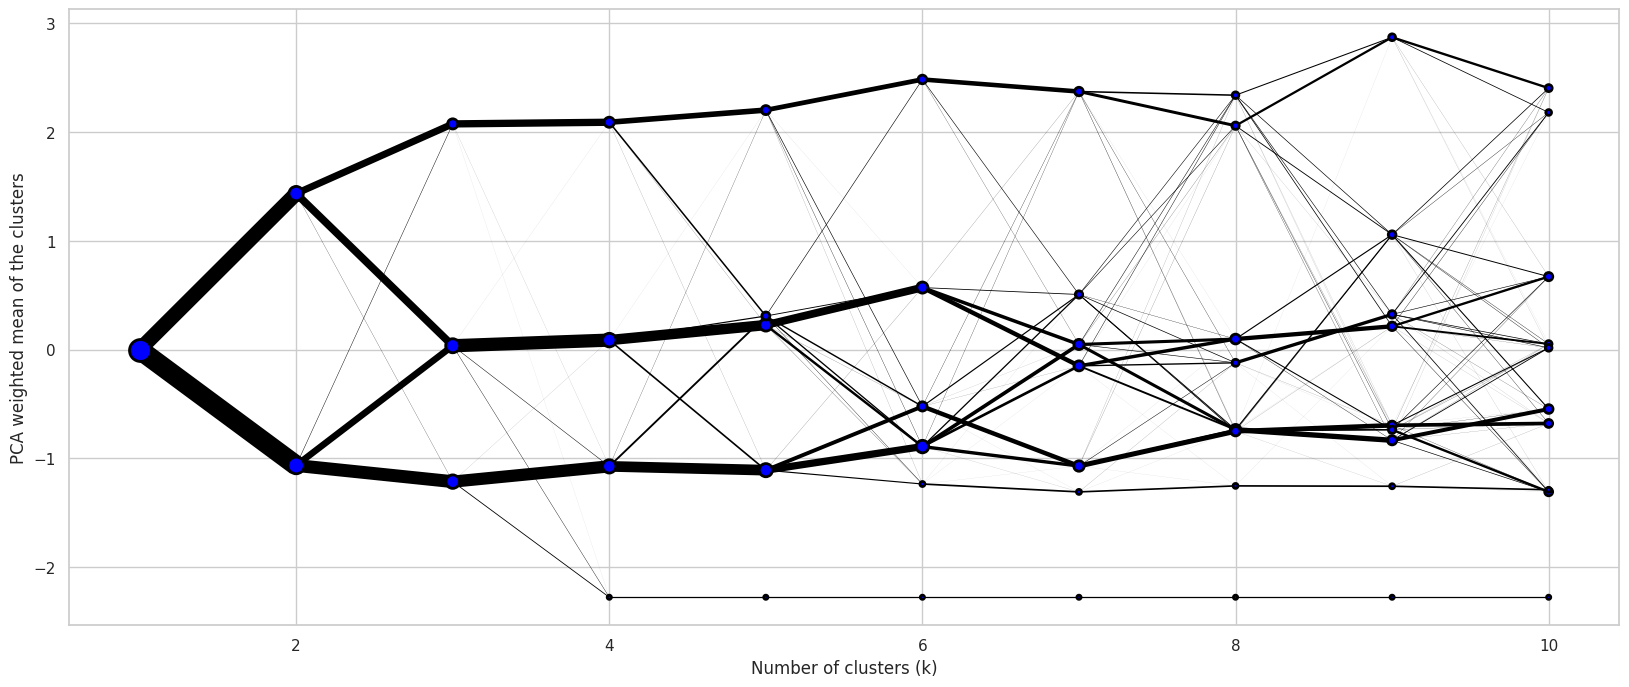

In [ ]:
sns.set(style="whitegrid")

cgram = Clustergram(range(1, 11), backend="sklearn", method="kmeans", verbose=False, n_init=20)
cgram.fit(x_scaled)
cgram.plot(
    # ax=ax,
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "blue", "edgecolor": "black"},
    line_style={"color": "black", "linestyle": "-"},
    figsize=(20, 8),
    pca_weighted=True
)

Тут можна побачити, що дані розбиваються на 4 гілки:

3 товсті основні гілки, які іноді дяляться з іншими дуже малою кількістю даних;

і ще 1 тонка - незалежна, яка потім ніколи не перетинається з іншими. Можливо це - аутлеєри.

### TSNE

In [ ]:
reduced_full_data_for_visualization: np.ndarray = TSNE(n_components=3, random_state=RANDOM_STATE).fit_transform(x_scaled)

### Plot function

In [ ]:
def plot_clusterization(labels, data=reduced_full_data_for_visualization):
  fig = plt.figure(figsize=(10, 8))

  ax = fig.add_subplot(111, projection="3d")
  ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=20, c=labels, cmap="rainbow")

  plt.title("FULL DATASET CLUSTERING")
  plt.show()

## 1 ЕТАП. ПІДБИРАЄМО АЛГОРИТМ ТА МЕТРИКИ.

### KMeans

In [ ]:
for n_clusters in range(2, 6):
  print(f"n_clusters: {n_clusters}:")
  kmeans: KMeans = KMeans(n_clusters=n_clusters, n_init=50, max_iter=600, tol=0.00001, random_state=RANDOM_STATE).fit(X=x_scaled)

  labels: np.ndarray = kmeans.predict(X=x_scaled)
  make_matrics(X=x_scaled, labels=labels)

n_clusters: 2:
Silhouette Score (MAX is BETTER):        0.0790880922002517
Calinski-Harabasz Index (MAX is BETTER): 85.16469527596506
Davies-Bouldin Index (MIN is BETTER):    3.328221753515819

n_clusters: 3:
Silhouette Score (MAX is BETTER):        0.073146525693109
Calinski-Harabasz Index (MAX is BETTER): 76.7824557997035
Davies-Bouldin Index (MIN is BETTER):    2.992724232037485

n_clusters: 4:
Silhouette Score (MAX is BETTER):        0.08022514910146189
Calinski-Harabasz Index (MAX is BETTER): 73.46072507198153
Davies-Bouldin Index (MIN is BETTER):    2.5402259668283858

n_clusters: 5:
Silhouette Score (MAX is BETTER):        0.08634862266184412
Calinski-Harabasz Index (MAX is BETTER): 67.69826891333521
Davies-Bouldin Index (MIN is BETTER):    2.3853598959207942



Судячи з метрик, бачимо, що можна виділити 2 кращих результати: або 2 кластери або 5.

В загальному випадку від 2 до 5.

Значень 0: 447
Значень 1: 553
Silhouette Score (MAX is BETTER):        0.0790880922002517
Calinski-Harabasz Index (MAX is BETTER): 85.16469527596506
Davies-Bouldin Index (MIN is BETTER):    3.328221753515819



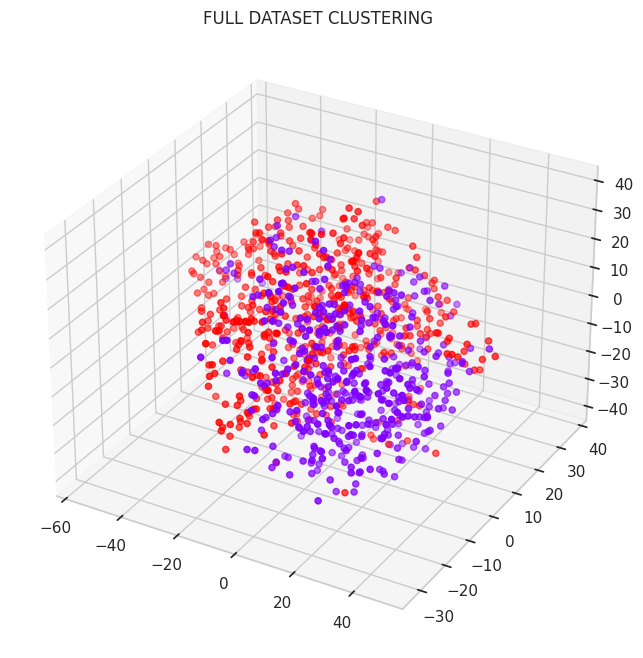

In [ ]:
kmeans: KMeans = KMeans(
    n_clusters=2,
    n_init=50,
    max_iter=600,
    tol=0.00001,
    random_state=RANDOM_STATE
).fit(X=x_scaled)
kmeans_labels: np.ndarray = kmeans.predict(X=x_scaled)

count_uniques(array=kmeans_labels)
make_matrics(X=x_scaled, labels=kmeans_labels)
plot_clusterization(labels=kmeans_labels)

### AgglomerativeClustering

In [ ]:
def find_best_agglomerative_clustering__n_clusters(X, search_range):
    for index in search_range:
      print(f"number of clusters: {index}:")
      agg_clusterizator: AgglomerativeClustering = AgglomerativeClustering(
          n_clusters=index,
          distance_threshold=None,
          compute_full_tree=True,
      ).fit_predict(X=X)

      make_matrics(X=X, labels=agg_clusterizator)

In [ ]:
find_best_agglomerative_clustering__n_clusters(X=x_scaled, search_range=range(2, 10))

number of clusters: 2:
Silhouette Score (MAX is BETTER):        0.12019273321109199
Calinski-Harabasz Index (MAX is BETTER): 56.21181319636569
Davies-Bouldin Index (MIN is BETTER):    2.901298515858864

number of clusters: 3:
Silhouette Score (MAX is BETTER):        0.13474934774866398
Calinski-Harabasz Index (MAX is BETTER): 58.167100039876075
Davies-Bouldin Index (MIN is BETTER):    2.4358657121623555

number of clusters: 4:
Silhouette Score (MAX is BETTER):        0.06269809728839609
Calinski-Harabasz Index (MAX is BETTER): 54.677147468204396
Davies-Bouldin Index (MIN is BETTER):    2.990397693845671

number of clusters: 5:
Silhouette Score (MAX is BETTER):        0.07304128579970984
Calinski-Harabasz Index (MAX is BETTER): 53.62587254096323
Davies-Bouldin Index (MIN is BETTER):    2.720145532576798

number of clusters: 6:
Silhouette Score (MAX is BETTER):        0.06426647610986141
Calinski-Harabasz Index (MAX is BETTER): 50.970929304345596
Davies-Bouldin Index (MIN is BETTER):    

Після проведених тестів, зробив висновок, що оптимальна кількість кластерів з алгоритмом AgglomerativeClustering - 3. Так як більшість метрик, показують гірший результат при числі кластерів 4 та більше.

Значень 0: 828
Значень 1: 136
Значень 2: 36


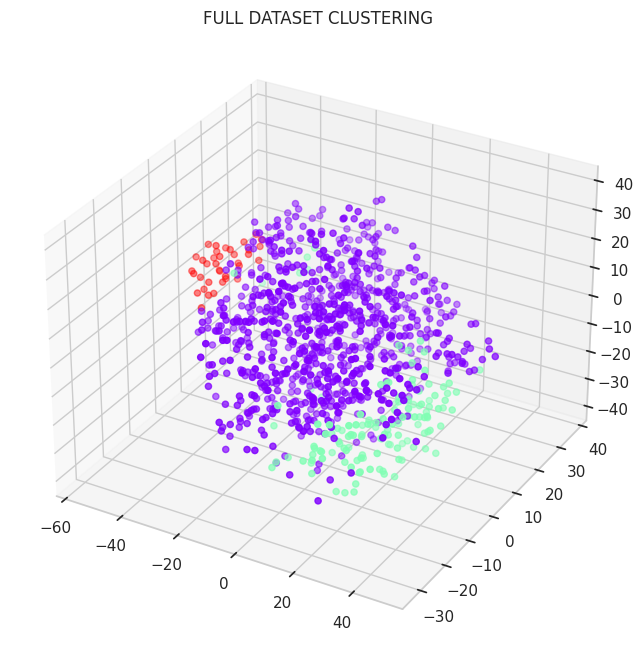

In [ ]:
agg_clusterizator: AgglomerativeClustering = AgglomerativeClustering(
    n_clusters=3,
    distance_threshold=None,
    compute_full_tree=True,
).fit_predict(X=x_scaled)

count_uniques(array=agg_clusterizator)
plot_clusterization(labels=agg_clusterizator)

In [ ]:
def find_best_agglomerative_clustering__distance(X, search_range):
    for index in search_range:
      print(f"distance: {index}:")
      agg_dist_clusterizator: AgglomerativeClustering = AgglomerativeClustering(
          n_clusters=None,
          distance_threshold=index
      ).fit(X=X)

      labels: np.ndarray = agg_dist_clusterizator.fit_predict(X=X)
      print(f"кількість кластерів: {len(np.unique(labels[labels != -1]))}")

      make_matrics(X=X, labels=labels)

In [ ]:
find_best_agglomerative_clustering__distance(X=x_scaled, search_range=np.arange(36, 48, 2))

distance: 36:
кількість кластерів: 5
Silhouette Score (MAX is BETTER):        0.07304128579970984
Calinski-Harabasz Index (MAX is BETTER): 53.62587254096323
Davies-Bouldin Index (MIN is BETTER):    2.720145532576798

distance: 38:
кількість кластерів: 5
Silhouette Score (MAX is BETTER):        0.07304128579970984
Calinski-Harabasz Index (MAX is BETTER): 53.62587254096323
Davies-Bouldin Index (MIN is BETTER):    2.720145532576798

distance: 40:
кількість кластерів: 3
Silhouette Score (MAX is BETTER):        0.13474934774866398
Calinski-Harabasz Index (MAX is BETTER): 58.167100039876075
Davies-Bouldin Index (MIN is BETTER):    2.4358657121623555

distance: 42:
кількість кластерів: 3
Silhouette Score (MAX is BETTER):        0.13474934774866398
Calinski-Harabasz Index (MAX is BETTER): 58.167100039876075
Davies-Bouldin Index (MIN is BETTER):    2.4358657121623555

distance: 44:
кількість кластерів: 3
Silhouette Score (MAX is BETTER):        0.13474934774866398
Calinski-Harabasz Index (MAX i

Провів додаткові тести з алгоритмом AgglomerativeClustering, через задану дистанцію, замість кількості кластерів. Тести підтвердили, що з цим алгоритмом оптимальна кількість кластерів - 3, так як:

1.   метрики показують найкращий результат саме на дистанціях, при яких кількість - 3

2.   найбільший розрив дистанцій: при дистанції від 40 до 46 - кількість кластерів - 3


Значень 0: 828
Значень 1: 136
Значень 2: 36


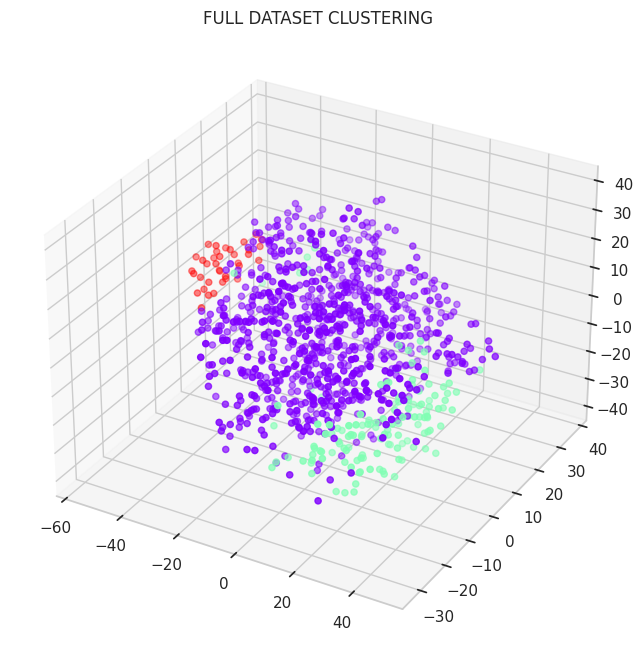

In [ ]:
agg_dist_clusterizator: AgglomerativeClustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=46
).fit(X=x_scaled)

agg_dist_labels: np.ndarray = agg_dist_clusterizator.fit_predict(X=x_scaled)

count_uniques(array=agg_dist_labels)
plot_clusterization(labels=agg_dist_labels)

### Birch

Значень 0: 846
Значень 1: 36
Значень 2: 118
Silhouette Score (MAX is BETTER):        0.1471090353570881
Calinski-Harabasz Index (MAX is BETTER): 57.64748528200177
Davies-Bouldin Index (MIN is BETTER):    2.3497875481129396



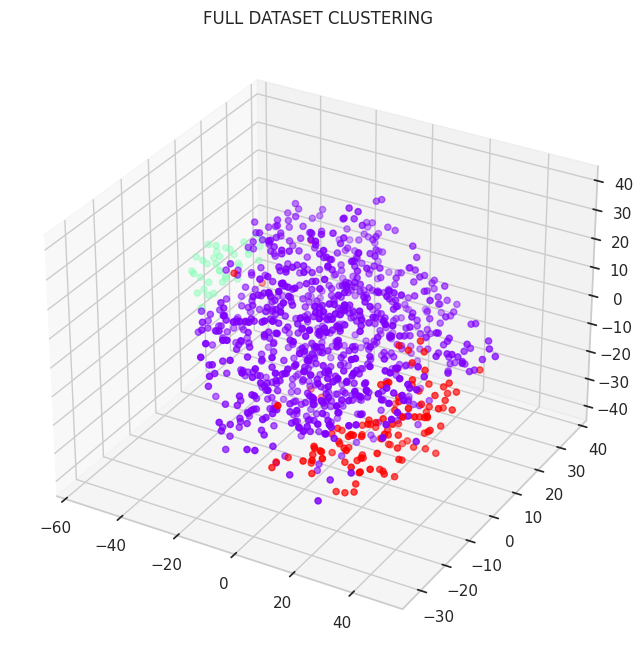

In [ ]:
birch_clusterizator: Birch = Birch().fit(X=x_scaled)
birch_labels: np.ndarray = birch_clusterizator.predict(X=x_scaled)

count_uniques(array=birch_labels)
make_matrics(X=x_scaled, labels=birch_labels)
plot_clusterization(labels=birch_labels)

Найкращі метрики з алгоритмом Birch також належать розбиттю на 3 кластери

### AgglomerativeClustering i Birch побудували однакові кластери

### HDBSCAN

За допомогою вкладених циклів визначили найкращі параметри розбиття, відібравши найкращі значення метрик.
* silhouette_ 0.24377225376290265
* calinski_harabasz_ 30.605266526106323
* davies_bouldin_ 1.5993034471595216
* size 10
* n_samples 2
* eps 4.9

Значень -1: 3
Значень 0: 961
Значень 1: 36
Silhouette Score (MAX is BETTER):        0.24377225376290265
Calinski-Harabasz Index (MAX is BETTER): 30.605266526106323
Davies-Bouldin Index (MIN is BETTER):    1.5993034471595216



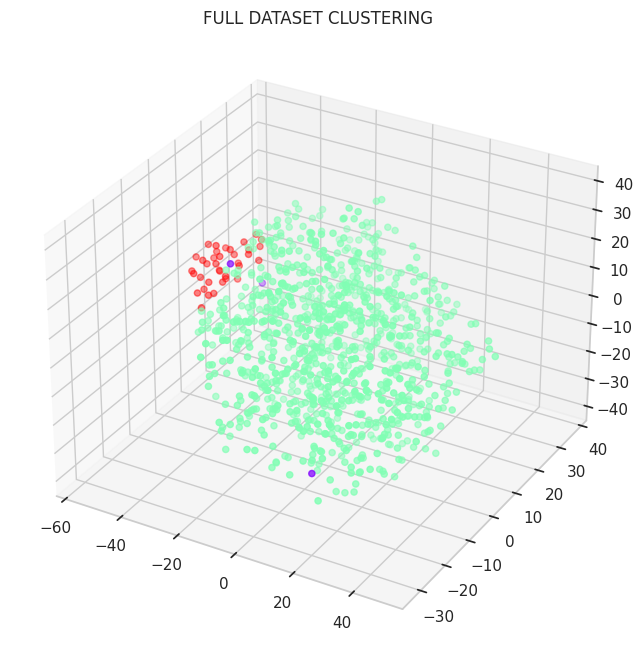

In [ ]:
hdb_clusterizator: HDBSCAN = HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    cluster_selection_epsilon=4.6,
    n_jobs=-1
).fit(X=x_scaled)
hdb_labels: np.ndarray = hdb_clusterizator.fit_predict(X=x_scaled)

count_uniques(array=hdb_labels)
make_matrics(X=x_scaled, labels=hdb_labels)
plot_clusterization(labels=hdb_labels)

HDBSCAN виділив той самий кусочок даник в окремий кластер, як і попередні алгоритми, але третій кластер так і не побачів.

### DBSCAN

Значень -1: 11
Значень 0: 956
Значень 1: 33
Silhouette Score (MAX is BETTER):        0.23616188307190047
Calinski-Harabasz Index (MAX is BETTER): 30.336027930399105
Davies-Bouldin Index (MIN is BETTER):    2.296292793619831



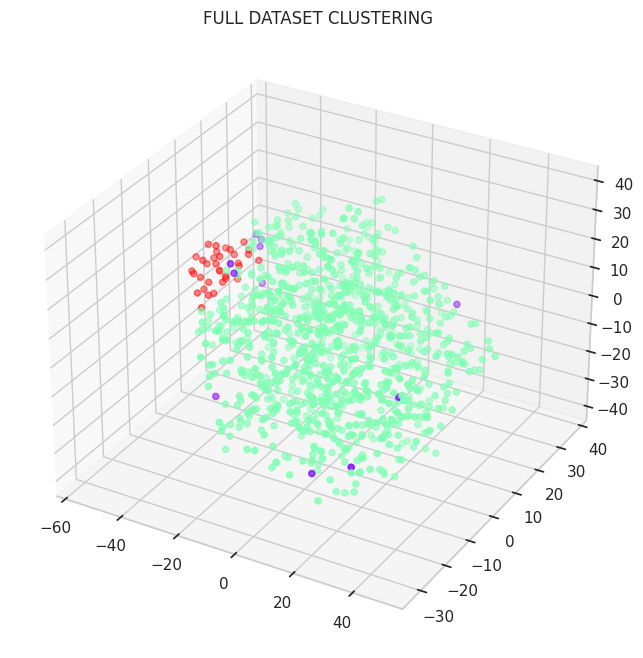

In [ ]:
dbscan_clusterizator: DBSCAN = DBSCAN(
    eps=5,
    min_samples=2,
    n_jobs=-1,
    p=2
).fit(X=x_scaled)
db_scan_labels: np.ndarray = dbscan_clusterizator.fit_predict(X=x_scaled)

count_uniques(array=db_scan_labels)
make_matrics(X=x_scaled, labels=db_scan_labels)
plot_clusterization(labels=db_scan_labels)

DBSCAN також як і HDBSCAN за найкращими метриками виділив 2 кластери. Кластери майже однакові з HDBSCAN

### Після порівняння розбиття на графіках, що методи розділилися на 3 групи.
### Перша група: Kmeans, цей алгоритм розибив на кластери посвоєму.
### Друга група: AgglomerativeClustering та Birch, вони однаково розбили датасет на 3 кластери.
### Третя група: DBSCAN/HDBSCAN, однаково розбили датасет на 2 кластери.

### *Хочу відмітити, що можна було привести майже всі алгоритми до однакового розбиття, але я принципово залишаю, так, як показують найкращі показники метрик.*


## 2 ЕТАП. ЗМЕНШУЄМО РОЗМІРНІСТЬ ДАНИХ (НЕ БІЛЬШЕ НІЖ НА 30%)

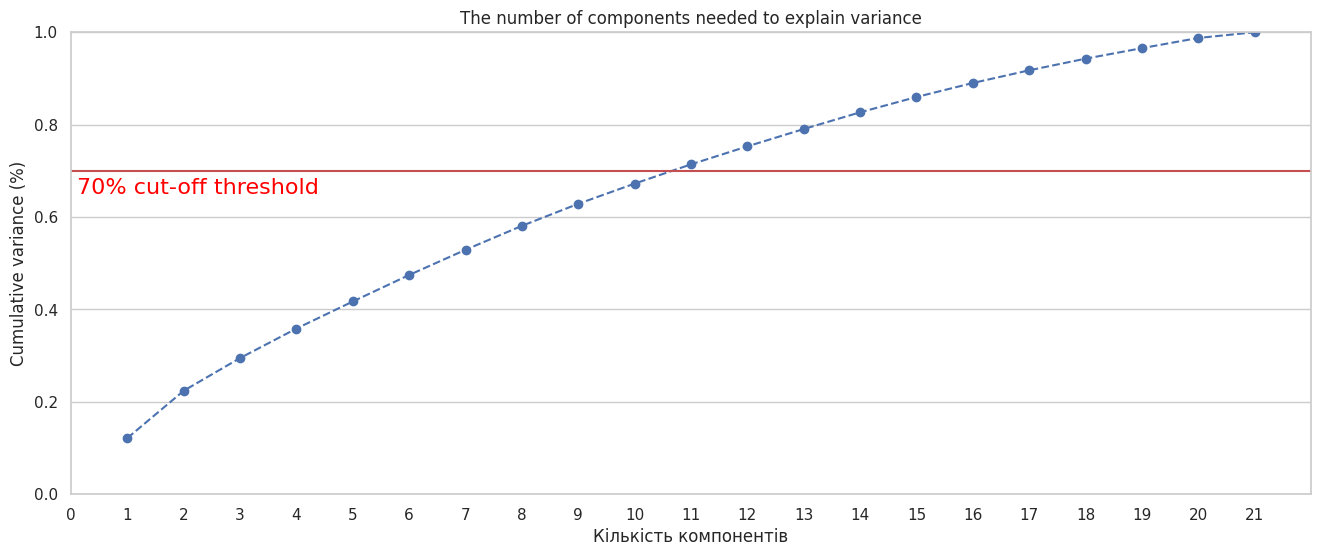

In [ ]:
pca: PCA = PCA().fit(X=x_scaled)

plt.rcParams["figure.figsize"] = (16,6)

fig, ax = plt.subplots()
xi: np.ndarray = np.arange(start=1, stop=22, step=1)
y: np.ndarray = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(bottom=0.0, top=1)
plt.plot(xi, y, marker="o", linestyle="--", color="b")

plt.xlabel(xlabel="Кількість компонентів")
plt.xticks(ticks=np.arange(0, 22, step=1))
plt.ylabel(ylabel="Cumulative variance (%)")
plt.title("The number of components needed to explain variance")

plt.axhline(y=0.7, color="r", linestyle="-")
plt.text(x=0.1, y=0.65, s="70% cut-off threshold", color="red", fontsize=16)

ax.grid(axis="x")
plt.show()

Як бачимо, нам необхідно зробити 11 компонентів при перетворенні, щоб втратити меньше ніж 30% інформації

Перетворюємо початковий датасет на новий з розмірністю у 11 компонентів (фічів)

In [ ]:
reduced_x_70p: np.ndarray = TSNE(n_components=11, method="exact", random_state=RANDOM_STATE).fit_transform(x_scaled)

## 3 ЕТАП. ПРОВОДИМО ДОСЛІДЖЕННЯ НА ПЕРЕТВОРЕНОМУ ДАТАСЕТІ

In [ ]:
reduced_70p_data_for_visualization: np.ndarray = TSNE(n_components=3, random_state=RANDOM_STATE).fit_transform(reduced_x_70p)

### KMeans

Значень 0: 525
Значень 1: 475
Silhouette Score (MAX is BETTER):        0.18237805366516113
Calinski-Harabasz Index (MAX is BETTER): 275.16517868544446
Davies-Bouldin Index (MIN is BETTER):    1.8860710857369987



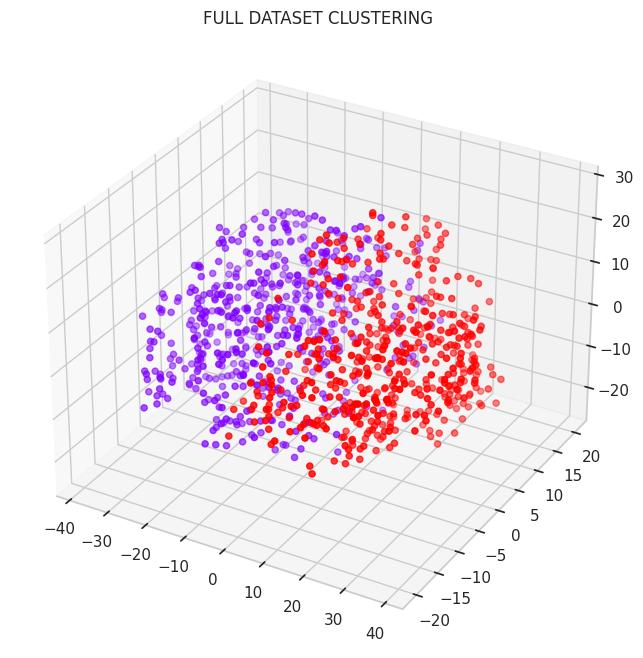

In [ ]:
kmeans_70p: KMeans = KMeans(
    n_clusters=2,
    n_init=50,
    max_iter=600,
    tol=0.00001,
    random_state=RANDOM_STATE
).fit(X=reduced_x_70p)
kmeans_labels_70p: np.ndarray = kmeans_70p.predict(X=reduced_x_70p)

count_uniques(array=kmeans_labels_70p)
make_matrics(X=reduced_x_70p, labels=kmeans_labels_70p)
plot_clusterization(labels=kmeans_labels_70p, data=reduced_70p_data_for_visualization)

KMeans як і на повному датасеті показує найкраще розбиття на 2 візуально майже однакові по кількості кластери.

### AgglomerativeClustering

**Тренуємо AgglomerativeClustering на кращій кількості кластерів:**

In [ ]:
find_best_agglomerative_clustering__n_clusters(X=reduced_x_70p, search_range=range(2, 6))

number of clusters: 2:
Silhouette Score (MAX is BETTER):        0.1642232984304428
Calinski-Harabasz Index (MAX is BETTER): 243.9129239898216
Davies-Bouldin Index (MIN is BETTER):    2.001954609861149

number of clusters: 3:
Silhouette Score (MAX is BETTER):        0.09315426647663116
Calinski-Harabasz Index (MAX is BETTER): 159.7140625430615
Davies-Bouldin Index (MIN is BETTER):    2.6479913136992224

number of clusters: 4:
Silhouette Score (MAX is BETTER):        0.06239304691553116
Calinski-Harabasz Index (MAX is BETTER): 122.59636438522021
Davies-Bouldin Index (MIN is BETTER):    3.1306942699360913

number of clusters: 5:
Silhouette Score (MAX is BETTER):        0.05744754895567894
Calinski-Harabasz Index (MAX is BETTER): 104.83564000888855
Davies-Bouldin Index (MIN is BETTER):    3.00018428922491



Тут найкращий результат показує розбиття на 2 кластери

Значень 0: 521
Значень 1: 479


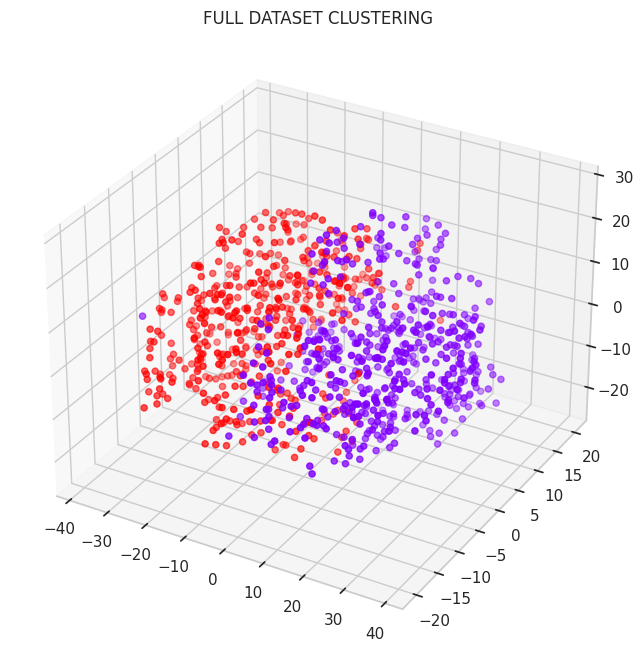

In [ ]:
agg_clusterizator_70p: AgglomerativeClustering = AgglomerativeClustering(
    n_clusters=2,
    distance_threshold=None,
    compute_full_tree=True,
).fit_predict(X=reduced_x_70p)

count_uniques(array=agg_clusterizator_70p)
plot_clusterization(labels=agg_clusterizator_70p, data=reduced_70p_data_for_visualization)

**Тренуємо AgglomerativeClustering на кращій дистанції:**

In [ ]:
find_best_agglomerative_clustering__distance(X=reduced_x_70p, search_range=np.arange(80, 100, 4))

distance: 80:
кількість кластерів: 3
Silhouette Score (MAX is BETTER):        0.09315426647663116
Calinski-Harabasz Index (MAX is BETTER): 159.7140625430615
Davies-Bouldin Index (MIN is BETTER):    2.6479913136992224

distance: 84:
кількість кластерів: 3
Silhouette Score (MAX is BETTER):        0.09315426647663116
Calinski-Harabasz Index (MAX is BETTER): 159.7140625430615
Davies-Bouldin Index (MIN is BETTER):    2.6479913136992224

distance: 88:
кількість кластерів: 2
Silhouette Score (MAX is BETTER):        0.1642232984304428
Calinski-Harabasz Index (MAX is BETTER): 243.9129239898216
Davies-Bouldin Index (MIN is BETTER):    2.001954609861149

distance: 92:
кількість кластерів: 2
Silhouette Score (MAX is BETTER):        0.1642232984304428
Calinski-Harabasz Index (MAX is BETTER): 243.9129239898216
Davies-Bouldin Index (MIN is BETTER):    2.001954609861149

distance: 96:
кількість кластерів: 2
Silhouette Score (MAX is BETTER):        0.1642232984304428
Calinski-Harabasz Index (MAX is BET

Тут також найкращий результат показує розбиття на 2 кластери, та найбільша дистанція саме між 2 кластерами. (від 86 до 178)

Значень 0: 521
Значень 1: 479


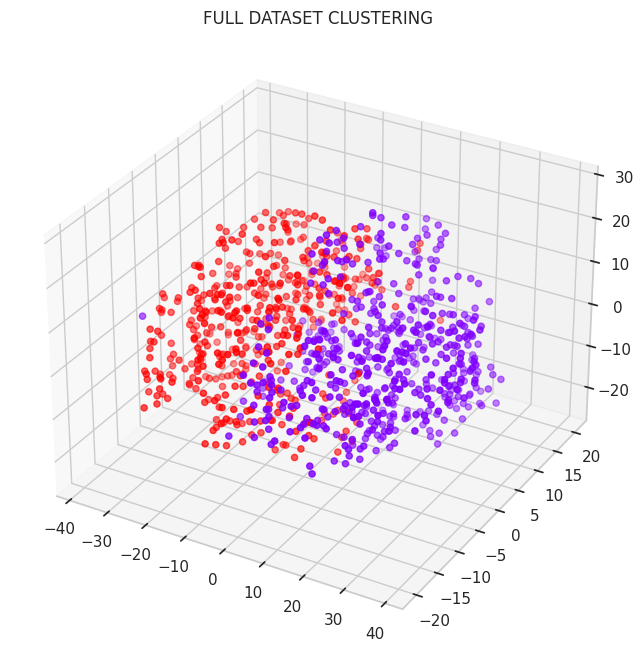

In [ ]:
agg_dist_clusterizato_70p: AgglomerativeClustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=86
).fit(X=reduced_x_70p)
agg_dist_labels_70p: np.ndarray = agg_dist_clusterizato_70p.fit_predict(X=reduced_x_70p)

count_uniques(array=agg_dist_labels_70p)
plot_clusterization(labels=agg_dist_labels_70p, data=reduced_70p_data_for_visualization)

Графіки побудовані Агромеративним класифікатором різними способами (через дистанцію та кількість кластерів) однакові.

### Birch

Значень 0: 521
Значень 1: 479
Silhouette Score (MAX is BETTER):        0.1642232984304428
Calinski-Harabasz Index (MAX is BETTER): 243.9129239898216
Davies-Bouldin Index (MIN is BETTER):    2.001954609861149



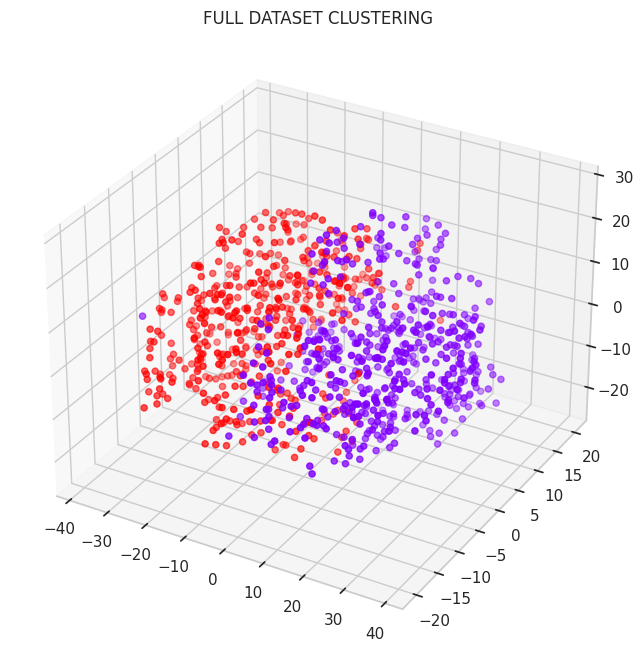

In [ ]:
birch_clusterizator_70p: Birch = Birch(
    threshold=0.5,
    branching_factor=50,
    n_clusters=2,
).fit(X=reduced_x_70p)
birch_labels_70p: np.ndarray = birch_clusterizator_70p.predict(X=reduced_x_70p)

count_uniques(array=birch_labels_70p)
make_matrics(X=reduced_x_70p, labels=birch_labels_70p)
plot_clusterization(labels=birch_labels_70p, data=reduced_70p_data_for_visualization)

Birch алгоритм також показує найкращий результат з 2 кластерами

### HDBSCAN

Значень -1: 1
Значень 0: 2
Значень 1: 2
Значень 2: 958
Значень 3: 37
Silhouette Score (MAX is BETTER):        -0.1385187953710556
Calinski-Harabasz Index (MAX is BETTER): 17.245040648731482
Davies-Bouldin Index (MIN is BETTER):    1.1944160477848542



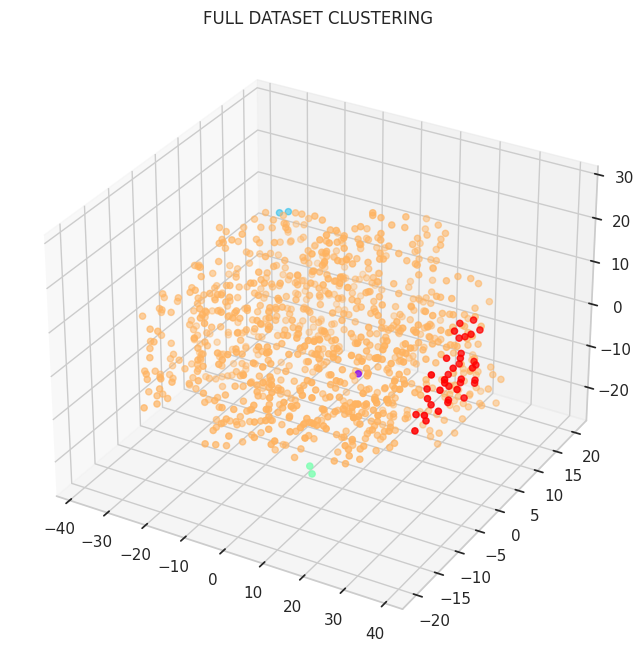

In [ ]:
hdb_clusterizator_70p: HDBSCAN = HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    cluster_selection_epsilon=6.36,
    n_jobs=-1
).fit(X=reduced_x_70p)
hdb_labels_70p: np.ndarray = hdb_clusterizator_70p.fit_predict(X=reduced_x_70p)

count_uniques(array=hdb_labels_70p)
make_matrics(X=reduced_x_70p, labels=hdb_labels_70p)
plot_clusterization(labels=hdb_labels_70p, data=reduced_70p_data_for_visualization)

Кількість кластерів, схожа з кількістю кластерізації повного датасету

### DBSCAN

Значень -1: 19
Значень 0: 945
Значень 1: 36
Silhouette Score (MAX is BETTER):        -0.007788658142089844
Calinski-Harabasz Index (MAX is BETTER): 32.005667541407185
Davies-Bouldin Index (MIN is BETTER):    4.781426419277827



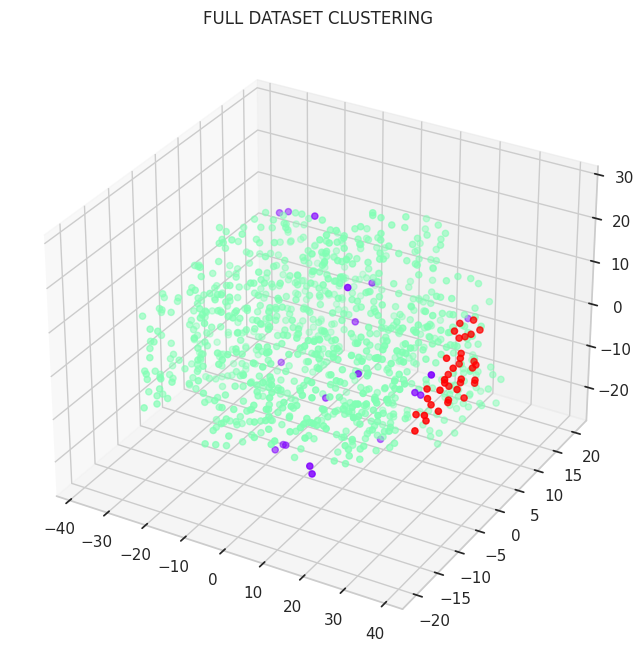

In [ ]:
dbscan_clusterizator_70p: DBSCAN = DBSCAN(
    eps=6,
    min_samples=4,
    n_jobs=-1,
).fit(X=reduced_x_70p)
db_scan_labels_70p: np.ndarray = dbscan_clusterizator_70p.fit_predict(X=reduced_x_70p)

count_uniques(array=db_scan_labels_70p)
make_matrics(X=reduced_x_70p, labels=db_scan_labels_70p)
plot_clusterization(labels=db_scan_labels_70p, data=reduced_70p_data_for_visualization)

Так само як і з HDBSCAN

### Після перетворення датасету, можна побачити, що 2 групи об'єдналися в одну: алгоритм KMeans, приєднався до AgglomerativeClustering та Birch. Мається на увзі, що метрики майже співпадають, а графіки абсолютно ідентичні, не дивлячісь на те, що з початку AgglomerativeClustering та Birch показували 3 кластери, та абсолютно іншу картинку.

### Порівняємо результати

**Kmeans**

In [ ]:
kmeans_comparison = kmeans_labels == kmeans_labels_70p
count_uniques(array=kmeans_comparison)

Значень False: 188
Значень True: 812


**AgglomerativeClustering**

In [ ]:
agg_comparison = agg_clusterizator == agg_clusterizator_70p
count_uniques(array=agg_comparison)

Значень False: 407
Значень True: 593


In [ ]:
agg_dist_comparison = agg_dist_labels == agg_dist_labels_70p
count_uniques(array=agg_dist_comparison)

Значень False: 407
Значень True: 593


**Birch**

In [ ]:
birch_comparison = birch_labels_70p == np.where(birch_labels == 2, 1, np.where(birch_labels == 1, 2, birch_labels))
count_uniques(array=birch_comparison)

Значень False: 413
Значень True: 587


HDBSCAN

In [ ]:
hdb_labels_70p = np.where(hdb_labels_70p == 2, 0, np.where(hdb_labels_70p == 0, 2, hdb_labels_70p))
hdb_labels_70p = np.where(hdb_labels_70p == 3, 1, np.where(hdb_labels_70p == 3, 1, hdb_labels_70p))

hdb_comparison = hdb_labels_70p == hdb_labels
count_uniques(array=hdb_comparison)

Значень False: 8
Значень True: 992


DBSCAN

In [ ]:
db_comparison = db_scan_labels == db_scan_labels_70p
count_uniques(array=db_comparison)

Значень False: 28
Значень True: 972


# Висновок

*Моделі, які на повному датасеті показали 3 кастери, а на зменшеному у розмірах, 2:*
* **AgglomerativeClustering**: збіг 593 з 1000. Але дивлячись на графіки, картинка дуже відрізняєть
* **Birch**: збіг 587 з 1000. Так само, картинка на графіках дуже відрязняється.

*Моделі, які і на повному датасеті і на зменшеному у розмірах, показали однакову кількість кластерів:*
* **Kmeans**: збіг кластерів на обох датасетах становить 812 з 1000. Це дуже багато, хоча спочатку здавалося що розподіл посередній.
* **DBSCAN**: Майже одаково розбив на кластери обидва датасети. Збіг становить 972 з 1000
* **HDBSCAN**: Переможець серед алгоритмів. Збіг 992 з 1000. В обох (HDBSCAN, DBSCAN) випадках другий кластер не дуже великий, але і за шум його не можна вважати. + Модель майже 100-відсотково виділила його в перетвореному датасеті.

Хочу відмітити, що якщо погратись з гіперпараметрами, то можна довесте деякі моделі до 100% співпадіння.

Можу сказати, судячи з порівнянь, що перетворення даних, не сильно відображається на якості даних (принаймні, в випадку з втратою 30%), і якщо це необхідно, то вважаю, можна робити перетворення, але на шкоду цілісності даних.

**В завершення: складно відповісти, яке розбиття є істинно вірним, для цього потрібно більш детально аналізувати вихідні дані, та отримані кластери. Але, судячи з того, що ми маємо дані людей, що брали кредити в бунку; і є розподіл на тих хто виплатив кредит, а хто ні. Тож я би віддав перевагу (за правилом "яких більше") розподілу Kmeans до перетворення даних, та розподілу що утворився після перетворення даних, (моделями Kmeans, AgglomerativeClustering та Birch), які показують розподіл двох кластерів майже 50/50. Але це лише мої думки, і як я сказав вище, для точного визначення потрібно аналізувати вхідні дані, та отримані кластери.**